In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud

from typing import Callable

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

import textstat
from razdel import tokenize

from tqdm.notebook import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
reviews = pd.read_csv('../data/final_data.csv')

In [3]:
reviews

,review,is_AI
0,Маска ложится на кожу как вторая кожа. Эффекти...,1
1,Размер и состав комплекта соответствует моим т...,1
2,"Покрывало мягкое и уютное, как домашний питоме...",1
3,Хорошая книга для детей. Иллюстрации яркие и и...,1
4,Этот комплект постельного белья выглядит довол...,1
...,...,...
11721,продавец отправил совсем не тот цвет который з...,0
11722,"Отличные Ленинск. Яркие, мягкие. На мой 42 р-р...",0
11723,"Это такое говно,что им только пыль вытирать, у...",0
11724,куртка пришла с браком! продавец не вернул де...,0


### WordCloud

CPU times: total: 4.09 s
Wall time: 7.68 s


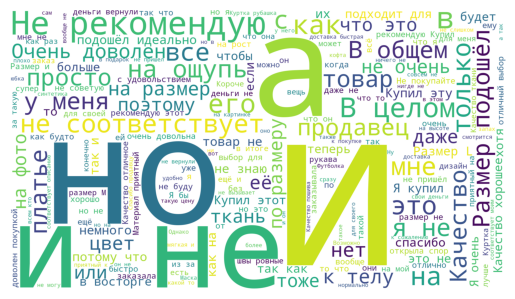

In [7]:
%%time

merged_text = reviews['review'].str.cat(sep=' ')

wc = WordCloud(width=1920, height=1080, background_color="white").generate(merged_text)
plt.imshow(wc)
plt.axis("off");

CPU times: total: 3.95 s
Wall time: 9.29 s


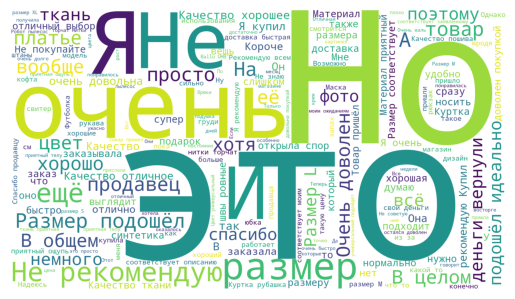

In [8]:
%%time

merged_text = reviews['review'].str.cat(sep=' ')
stop_words = set(stopwords.words('russian'))
filtered_words = [word for word in merged_text.split() if word not in stop_words]
filtered_text = ' '.join(filtered_words)

wc = WordCloud(width=1920, height=1080, background_color="white").generate(filtered_text)
plt.imshow(wc)
plt.axis("off");

CPU times: total: 2.56 s
Wall time: 8.2 s


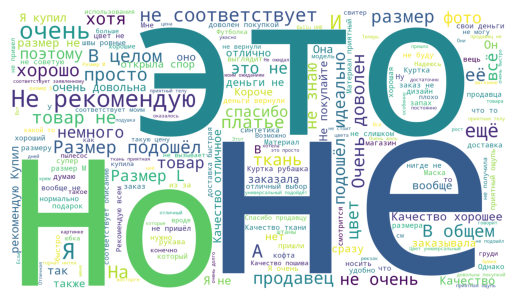

In [9]:
%%time

merged_text = reviews['review'].str.cat(sep=' ')
stop_words = set(stopwords.words('russian'))
stop_words.remove('не')
filtered_words = [word for word in merged_text.split() if word not in stop_words]
filtered_text = ' '.join(filtered_words)

wc = WordCloud(width=1920, height=1080, background_color="white").generate(filtered_text)
plt.imshow(wc)
plt.axis("off");

In [10]:
from pymorphy3 import MorphAnalyzer

morph = MorphAnalyzer()
morph.parse('машина')[0].normal_form

'машина'

### Text Cleaning

In [4]:
def clean_text(text):
    from razdel import tokenize
    from pymorphy3 import MorphAnalyzer
    from nltk.corpus import stopwords

    text = text.lower()

    sw_to_drop = ['не']
    
    morph = MorphAnalyzer()
    sws = set(stopwords.words('russian'))

    for sw in sw_to_drop:
        sws.remove(sw)
    
    tokens = tokenize(text)
    tokens = [morph.parse(token.text)[0].normal_form for token in tokens]
    tokens = [token for token in tokens if token not in sws]

    return ' '.join(tokens) 

In [5]:
reviews['processed_text'] = reviews['review'].parallel_apply(clean_text)

In [6]:
reviews

,review,is_AI,processed_text
0,Маска ложится на кожу как вторая кожа. Эффекти...,1,маска ложиться кожа второй кожа . эффективно у...
1,Размер и состав комплекта соответствует моим т...,1,размер состав комплект соответствовать требова...
2,"Покрывало мягкое и уютное, как домашний питоме...",1,"покрывало мягкий уютный , домашний питомец . ц..."
3,Хорошая книга для детей. Иллюстрации яркие и и...,1,хороший книга ребёнок . иллюстрация яркий инте...
4,Этот комплект постельного белья выглядит довол...,1,комплект постельный бельё выглядеть довольно п...
...,...,...,...
11721,продавец отправил совсем не тот цвет который з...,0,продавец отправить не цвет который заказывать ...
11722,"Отличные Ленинск. Яркие, мягкие. На мой 42 р-р...",0,"отличный ленинск . яркий , мягкий . 42 р-р рос..."
11723,"Это такое говно,что им только пыль вытирать, у...",0,"это говно , пыль вытирать , ужасно разачеровать"
11724,куртка пришла с браком! продавец не вернул де...,0,куртка прийти брак ! продавец не вернуть деньг...


### Zipf Distribution

In [68]:
def plot_zipf_diagram(texts: pd.Series) -> None:
    from collections import Counter
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 10))
    
    text = texts.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    labels = [label for label, count in counts]
    counts = [count for label, count in counts]
    plt.bar(counts, range(len(set(tokens))))
    plt.xlim(0, 250)


def compare_zipf_diagrams(texts_real: pd.Series, texts_generated: pd.Series):
    from collections import Counter
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 6))

    text = texts_generated.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    labels, values = [], []
    for label, value in counts:
        labels.append(label)
        values.append(value)
    plt.bar(range(len(set(tokens))), values, label='generated')
    
    text = texts_real.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    labels, values = [], []
    for label, value in counts:
        labels.append(label)
        values.append(value)
        
    plt.bar(range(len(set(tokens))), values, label='real')
    
    plt.xlim(0, 250)
    plt.title('Zipf Distribution')
    plt.xlabel('Some word index')
    plt.ylabel('Number of occurrencies')

    plt.grid()
    plt.legend()
    plt.tight_layout()

In [69]:
reviews.is_AI.value_counts()

is_AI
1    5863
0    5863
Name: count, dtype: int64

**Для оригинальных отзывов**

CPU times: total: 32.8 s
Wall time: 32.9 s


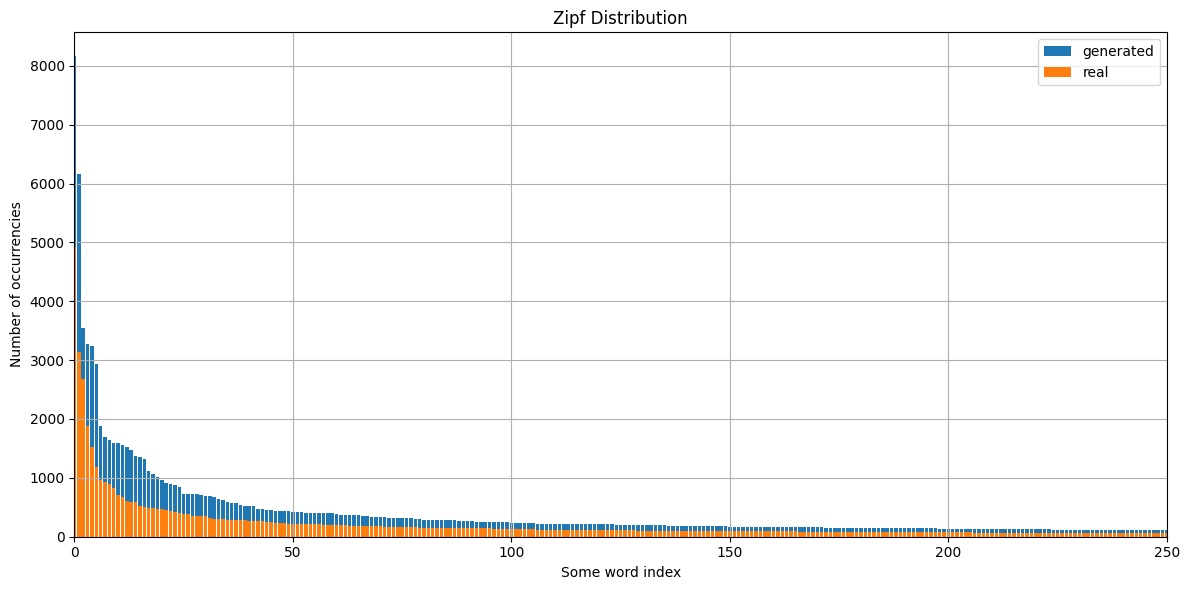

In [70]:
%%time

compare_zipf_diagrams(reviews.query('is_AI == 0')['review'], reviews.query('is_AI == 1')['review'])

**Для предобработанных отзывов**

CPU times: total: 11.9 s
Wall time: 12.1 s


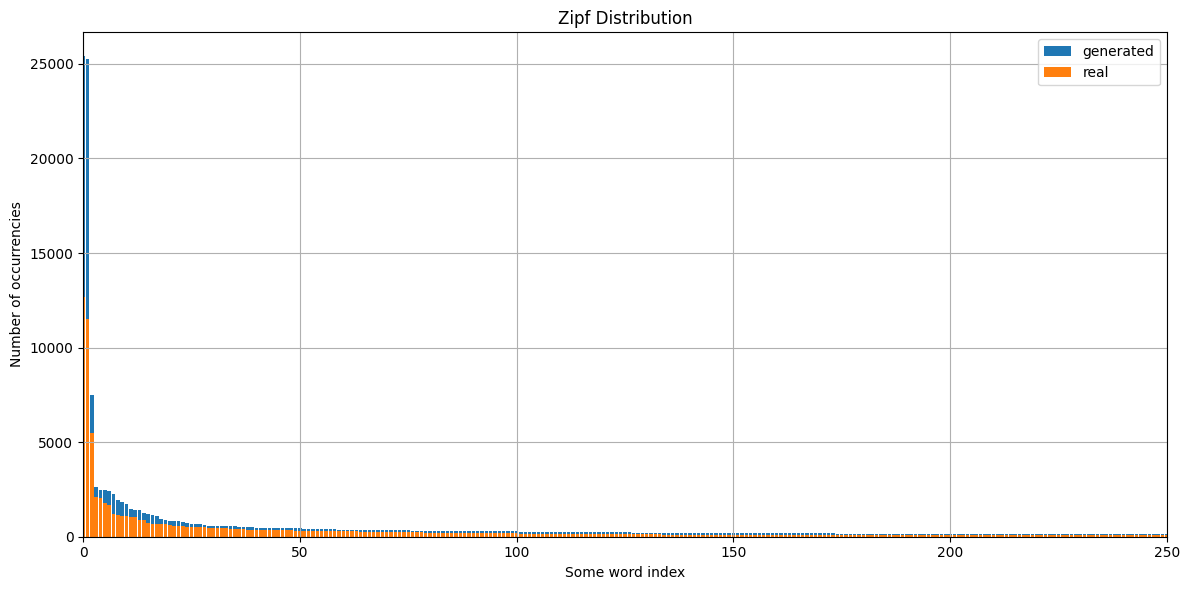

In [82]:
%%time

compare_zipf_diagrams(reviews.query('is_AI == 0')['processed_text'], reviews.query('is_AI == 1')['processed_text'])

### Just words distribution

In [125]:
def get_words_number_of_occurrencies(texts: pd.Series) -> pd.DataFrame:
    from collections import Counter

    text = texts.str.cat(sep=' ')
    tokens = text.split()
    counts = Counter(tokens).most_common()
    df = pd.DataFrame(counts)
    return df



In [126]:
real = get_words_number_of_occurrencies(reviews.query('is_AI == 0')['processed_text'])
real.index = real[0]
real.drop(columns=[0], inplace=True)
generated = get_words_number_of_occurrencies(reviews.query('is_AI == 1')['processed_text'])
generated.index = generated[0]
generated.drop(columns=[0], inplace=True)

In [127]:
real

,1
0,
",",12691
.,11524
не,5477
очень,2088
размер,2022
...,...
-вау,1
ленинск,1
вытирать,1


In [128]:
generated

,1
0,
",",25399
.,25267
не,7506
размер,2646
!,2489
...,...
слякоть,1
соседа-творческий,1
талантливый,1


In [134]:
real, generated = real.align(generated, axis=0, fill_value=0.0)
stats = pd.concat([real, generated], axis=1)
stats.columns = ['real', 'generated']
stats

,real,generated
0,,
!,1768.0,2489.0
!!,95.0,3.0
!!!,351.0,1.0
!!!!,108.0,0.0
!!!!!,40.0,0.0
...,...,...
😞,0.0,1.0
😡🗑️☁,0.0,1.0
😡🤬,0.0,1.0


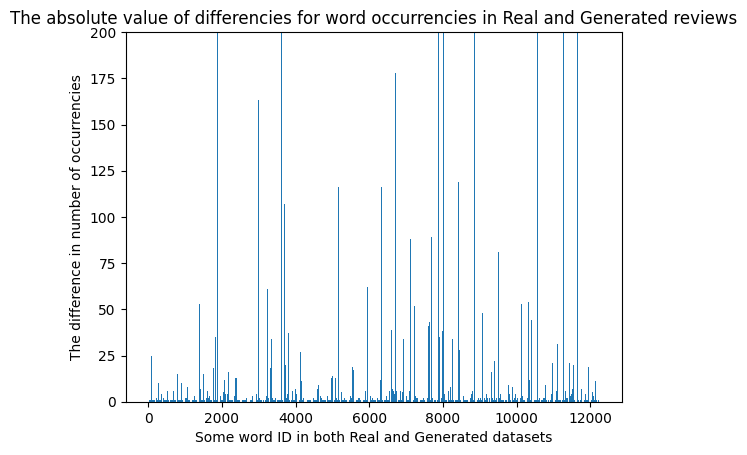

In [138]:
plt.bar(range(len(stats)), (stats['real'] - stats['generated']).abs(), label='real')
plt.title('The absolute value of differencies for word occurrencies in Real and Generated reviews')
plt.xlabel('Some word ID in both Real and Generated datasets')
plt.ylabel('The difference in number of occurrencies')
plt.ylim(0, 200);

### TextStat

In [11]:
meth_ignore_list = ['set_lang',  # Not appropriate
                    'wiener_sachtextformel']
good_methods: dict[str, Callable] = {}

for meth_name in dir(textstat):
    # print(meth_name)
    if not meth_name.startswith('__') and meth_name not in meth_ignore_list:
        meth = getattr(textstat, meth_name)
        if isinstance(meth, Callable):
            try:
                res = meth(reviews['processed_text'].iloc[0])
                if isinstance(res, (int, float, bool)):
                    print(meth_name, res)   
                    good_methods[meth_name] = meth
            except Exception as e:
                print(e)
                raise e

def apply_textstat(text, meth): 
    try:
        res = meth(text)
    except OSError:
        return None
    except ZeroDivisionError:
        return None
    return res


# X_train = X.copy()
# y_train = y.copy()
# X_test = test.copy()

for meth_name, meth in tqdm(good_methods.items()):
    reviews[meth_name] = reviews['review'].progress_apply(apply_textstat, args=(meth,))
for meth_name, meth in tqdm(good_methods.items()):
    reviews[meth_name] = reviews['review'].progress_apply(apply_textstat, args=(meth,))

automated_readability_index 11.6
avg_character_per_word 6.48
avg_letter_per_word 6.28
avg_sentence_length 5.0
avg_sentence_per_word 0.2
avg_syllables_per_word 1.0
char_count 162
coleman_liau_index 14.7
count_arabic_long_words 14
count_arabic_syllables 155
count_complex_arabic_words 0
count_faseeh 0
crawford -2.7
dale_chall_readability_score 17.78
dale_chall_readability_score_v2 3.88
difficult_words 0
fernandez_huerta 141.74
flesch_kincaid_grade -1.9
flesch_reading_ease 117.16
gulpease_index 84.2
gunning_fog 2.0
gutierrez_polini 32.53
is_difficult_word True
is_easy_word False
letter_count 157
lexicon_count 25
linsear_write_formula 2.0
lix 38.33
long_word_count 10
mcalpine_eflaw 5.4
miniword_count 2
monosyllabcount 25
osman 32.25
polysyllabcount 0
reading_time 2.38
rix 2.0
sentence_count 5
smog_index 3.1
spache_readability 1.54
syllable_count 25
szigriszt_pazos 139.54
words_per_sentence 5.0


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

  0%|          | 0/11726 [00:00<?, ?it/s]

In [ ]:
reviews.head(3)

In [ ]:
reviews.isna().any()

In [31]:
reviews.to_csv('./reviews_preprocessed_with_textstat.csv', index=False)

  0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_17872\1744063771.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../images/{col}.png')
C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_17872\1744063771.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


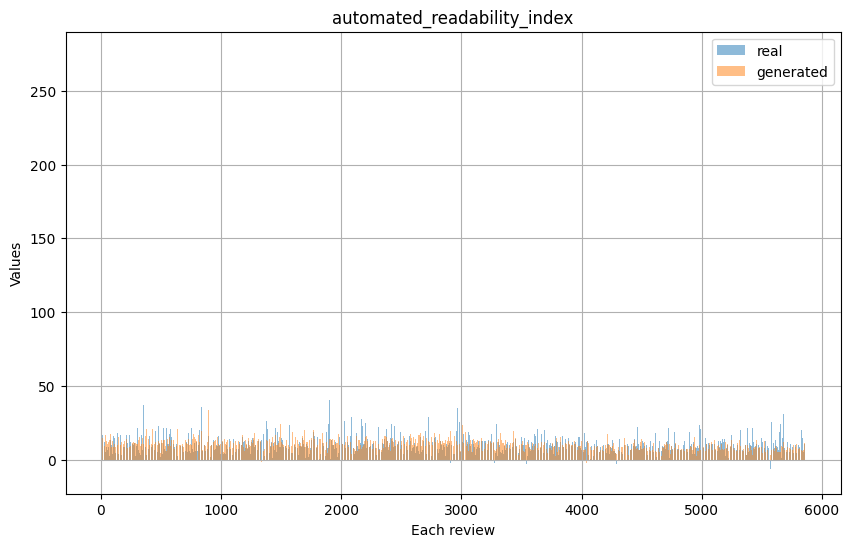

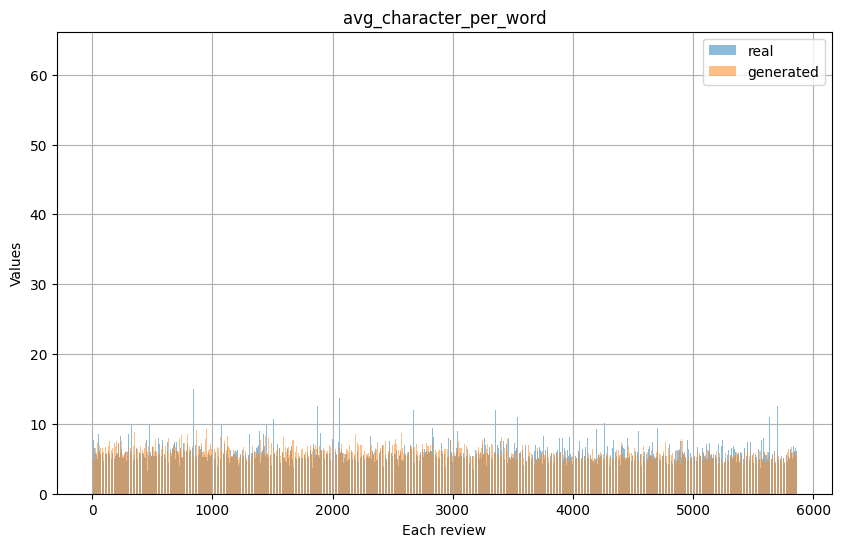

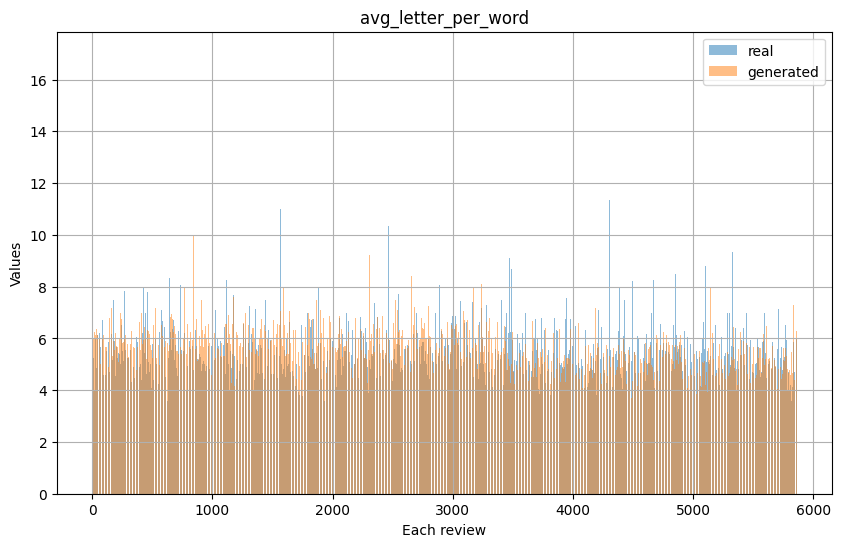

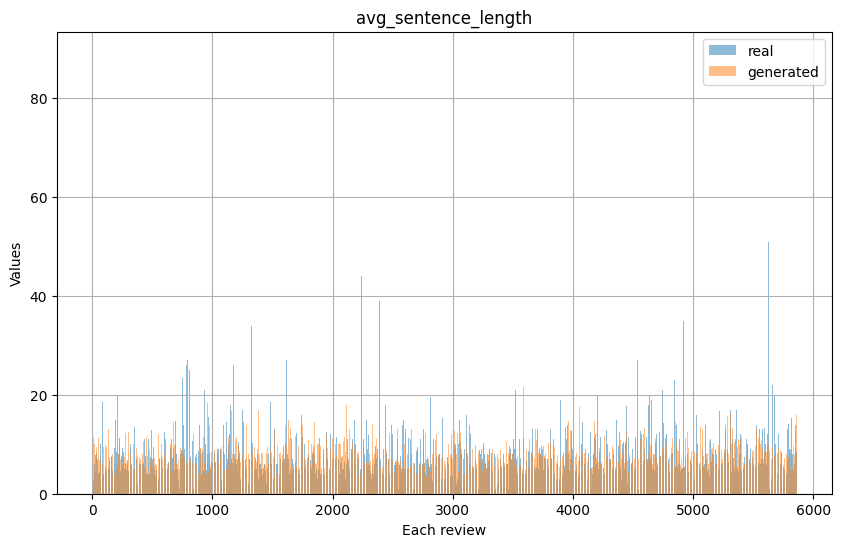

D:\ProgramData\anaconda3\envs\kaggle\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x0000020D17FDAF70> (for post_execute):



KeyboardInterrupt



In [11]:
for col in tqdm(reviews.columns[3:]):
    plt.figure(figsize=(10, 6))
    for is_AI in (0, 1):
        cur_df = reviews.query('is_AI == @is_AI')
        plt.bar(range(len(cur_df)), cur_df[col], alpha=0.5, label='generated' if is_AI == 1 else 'real')

    plt.title(col)
    plt.xlabel('Each review')
    plt.ylabel('Values')
    plt.grid()
    plt.legend()
    plt.savefig(f'../images/{col}.png')


  0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_17872\1482363134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_df.sort_values(col, ascending=False, inplace=True)
C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_17872\1482363134.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
C:\Users\Yaroslav Pristalov\AppData\Local\Temp\ipykernel_17872\1482363134.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'../images_sorted_hist/{col}

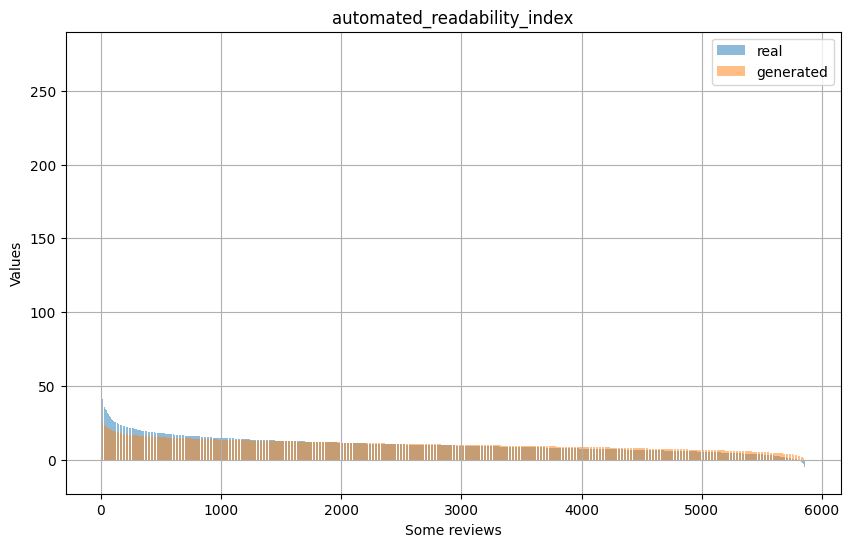

Error in callback <function flush_figures at 0x0000020D17FDAF70> (for post_execute):



KeyboardInterrupt



In [13]:
for col in tqdm(reviews.columns[3:]):
    plt.figure(figsize=(10, 6))
    for is_AI in (0, 1):
        cur_df = reviews.query('is_AI == @is_AI')
        cur_df.sort_values(col, ascending=False, inplace=True)
        plt.bar(range(len(cur_df)), cur_df[col], alpha=0.5, label='generated' if is_AI == 1 else 'real')

    plt.title(col)
    plt.xlabel('Some reviews')
    plt.ylabel('Values')
    plt.grid()
    plt.legend()
    plt.savefig(f'../images_sorted_hist/{col}.png')
None

### `ydata_profiling`

In [ ]:
# !pip install ydata_profiling

In [8]:
from ydata_profiling import ProfileReport

profile = ProfileReport(reviews, title="Profiling Report")

In [13]:
with open('ydata_profiling.html', 'wt', encoding='UTF-8') as f:
    f.write(profile.to_html())